# Tutorial analysis a dataset with unknown correlation in the noise

## Consider a model with single Gaussian feature with the parameters $a, \; b, \; \sigma^2$. 

## Also, consider the following simulated dataset with 100 data points with known correlated noise.

## White noise: 
## Firstly, consider uncorreleted noise, for this, we use the Ln-likelihood function for the data set $\{y_n\}$ and the parameters $\theta$ 

In [20]:
import emcee
from george.modeling import Model 

class Model(Model):
    parameter_names = ("amp","location","log_sigma2")

    def get_value(self,t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))




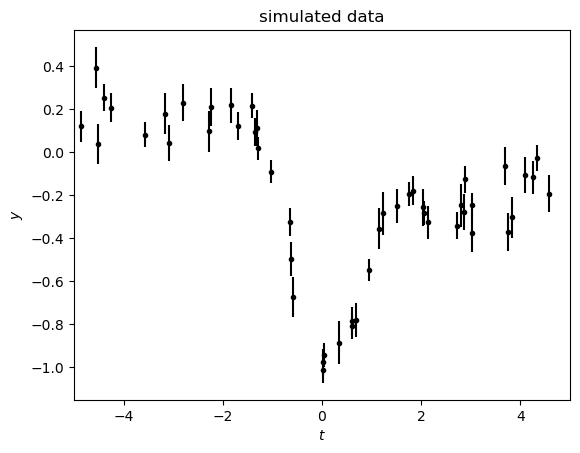

In [18]:
import numpy as np
import matplotlib.pyplot as pl
import george 
from george import kernels

np.random.seed(1234)

def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data");

In [19]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")
    
    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

In [21]:
model = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)))
model.compute(t, yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()


In [22]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


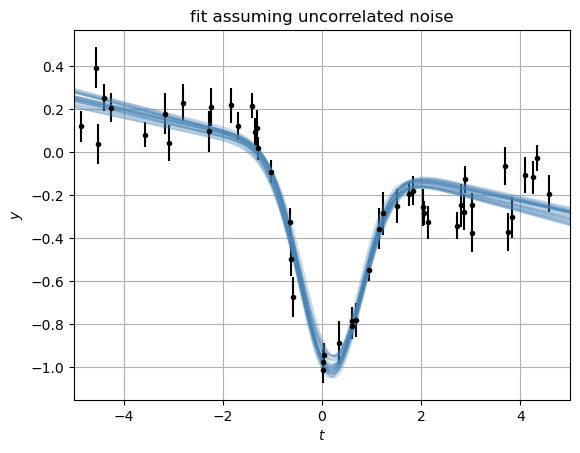

In [24]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)
    
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.grid()
pl.title("fit assuming uncorrelated noise");